In [1]:
%matplotlib inline

from typing import Tuple

import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_blobs, make_moons
from matplotlib import pyplot as plt

plt.style.use("fivethirtyeight")

np.random.seed(42)

# Fundamentals of Deep Learning

In this notebook, we'll cover the fundamentals of deep learning by implementing our own relatively low level building blocks of neural networks using Python and NumPy.

The idea behind this notebook is to set up the core parts that will be repeatedly used and re-used in virtually all deep learning applications. The notebooks following this will have many of these concepts abstracted away by using higher level libraries, where most of the grunt work is not only done, but more than likely a lot more efficiently than we could do in a mere few hours.

To kick things off, we'll look at this humble equation:

$$ y = mx + b $$

which is your typical linear regression, with slope $m$ and offset $b$. The power of this expression is its simplicity: we are able to map inputs $x$ more or less directly (with two parameters) onto an output value $y$. When we're dealing with multidimensional data, the same rule applies: we just make $x$ a vector, and do multivariate linear regression. The advantage of such simplicity is in its ability to be explained; we interpret each parameter with a specific purpose—for example, $m$ is the slope, and tells us how quickly $y$ changes with $x$, and so on.

In [2]:
x = np.linspace(0., 10., 100)
y = 2.31531 * x + 0.23412 + np.random.normal(size=(x.size))

# The array slicing here is actually a useful trick to create another dimension
# scikit-learn modules expect 2D arrays for most of their inputs
model = LinearRegression(fit_intercept=True)
model.fit(x[:,None], y[:,None])

y_pred = model.predict(x[:,None])

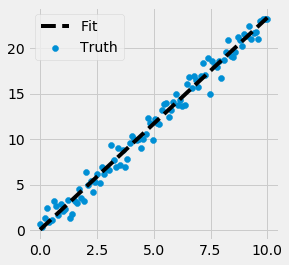

In [3]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(x, y, label="Truth")
ax.plot(x, y_pred.flatten(), label="Fit", color="k", ls="--")

ax.legend()

However, the power and weakness of linear regression is its simplicity. While it's readily interpretable, it doesn't have much _expressive power_: the number of things you can do with linear regression is big, but it's also very strictly useful for a very specific purpose. One of the problems with science and statistics up to now the fascination with linear regression, just because it's easy, and consequently our tendency to jump through hoops to fit linear trends to non-linear data.

Take for example the datasets below:

In [4]:
blob_data, blob_labels = make_blobs(200, centers=[[0.,1], [0., -1]], random_state=0)
# unpack the data into "X" and "Y" dimensions
blob_x, blob_y = blob_data[:,0], blob_data[:,1]

moon_data, moon_labels = make_moons(200, noise=0.1, random_state=0)
# unpack the data into "X" and "Y" dimensions
moon_x, moon_y = moon_data[:,0], moon_data[:,1]

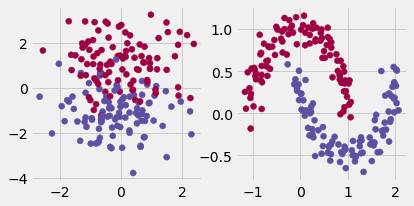

In [5]:
fig, axarray = plt.subplots(1, 2, figsize=(6,3))

axarray[0].scatter(blob_x, blob_y, c=blob_labels, cmap="Spectral")
axarray[1].scatter(moon_x, moon_y, c=moon_labels, cmap="Spectral")

If our task was to sort data points depending on their origin (i.e. a classification problem), linear regression might be able to do reasonably well on the left panel (blobs), where the decision boundary separating the two could be closely approximated by a straight line. In the right panel (moons), the dividing boundary does not appear to be a linear function! In the conventional way of thinking, we could probably find some projection of the data where it is linear, but to what end? You will likely lose the interpretability of model, and you would have to think hard about how to perform the transformations with sufficient confidence that will capture the underlying problem enough to be predictive.

---

# Enter Neural Networks

If our data is sufficiently complex, then it may be a better option to let the data speak for itself, rather than imposing what _we think_ the data should look like. Instead of applying crazy transformations, why not transform our model? This is where neural networks come into play.

The idea behind neural networks is simple, and in the simplest case can be written out as a simple linear algebra equation:

$$ Y = w^TX + b $$

Note that here I'm using vector notation: $X$ and $Y$ are no longer restricted to scalar quantities, but the equation more or less looks the same as our linear regression equation. The main difference is $m$ used to be our slope, is now replaced by a vector $w$ which represents "weights". You now have an added level of complexity/expressive power in your model by having multiple free parameters rather than a single value. In general, $w$ is a rank two tensor, or a matrix (as we'll see later).

In [6]:
def linear_layer(X: np.ndarray, w: np.ndarray, b: np.ndarray):
    """
    NumPy implementation of a "fully connected layer". 
    Dot product of transposed weights and X, plus a bias term.
    """
    return w.T @ X + b

So how can we use this?

Let's take a simple example of a two layer model, which is the simplest type of neural network you can have. 

![simple](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/280px-Colored_neural_network.svg.png)

It's convenient to define some nomenclature here:

| Term | Definition |
|---|---|
| Unit | One of the nodes on our graph. Also referred to as a neuron. |
| Layer | One of the columns on our graph |
| Hidden Layer | Intermediate layers between input/output. Hidden because you don't typically see the actual computation/values. |
| Fully-connected | Every node is connected to every node in the previous layer. This is important for defining the flow of your graph. |
| Deep | Neural network with many layers deep; somewhat arbitrary (more than four layers?). |

There are two layers, as the output counts as a layer of the network, but the inputs do not. Here, we have an intermediate—or "hidden"—layer in between the inputs and outputs that performs our transformation. This kind of network is also called a perceptron, and in our two-layer case is the special case of a [linear perceptron](https://en.wikipedia.org/wiki/Perceptron). To compute the  first "hidden" part, we simply have to take our weights $w$, compute the dot product with our inputs.

The shape of these matrices are worth bringing up: there's quite a bit of nuance because of the way these equations are set up. While we would like to think of $w$ as a vector, it is actually a matrix that connects the inputs (length 3) with the hidden (length 4) layer.

In [7]:
X = np.random.randn(3, 1)
# Shape 3,4 — input length, hidden dimension
w = np.random.randn(3, 4)
# bias is a single term for each neuron
b = np.random.randn(4, 1)

In [8]:
h = linear_layer(X, w, b)
print(f"Hidden layer: \n{h}")
print(f"Shape of hidden layer: \t{h.shape}")

Hidden layer: 
[[ 1.37271847]
 [ 0.06458817]
 [-2.5534333 ]
 [-0.65378249]]
Shape of hidden layer: 	(4, 1)


If we wanted to make our model more expressive, we could increase our hidden dimension—replace 4 with some large number. We'll get to that later, but for now we can finish this model by computing the next step.

In [9]:
w = np.random.randn(4, 2)
# Not using bias on the output layer
b = np.zeros((2, 1))

In [10]:
Y = linear_layer(h, w, b)
print(f"Output layer: \n{Y}")
print(f"Shape of output: \t{Y.shape}")

Output layer: 
[[3.12090834]
 [0.32556294]]
Shape of output: 	(2, 1)


And that's it! That's actually all you need to implement a simple neural network. Of course, the complication is in many of the other nuanced factors: our code isn't very general, nor is it a very practical way to use neural networks. We're still a far way away from treating the blob and moon problems, but in principle this is all our computation requires.

For the sake of abstraction, let's play around with making a class that will set up a multilayer perceptron: a fully connected, $n$ hidden layer neural network. If you are smart enough to do it recursively, do it!

In [11]:
class LinearModel:
    def __init__(self, X_dim: int, Y_dim: int, hidden_dims: Tuple[int]):
        self.X_dim = X_dim
        self.Y_dim = Y_dim
        self.hidden_dims = hidden_dims
        self.w = list()
        self.b = list()
        # Number of layers is hidden + output
        self.n_layers = len(hidden_dims) + 1
        self.init_parameters()
        
    def init_parameters(self):
        """
        The first and last have to match the input and output shapes; while
        this is bad code, it's supposed to be more readable/easily understood.
        """
        self.w = list()
        self.b = list()
        for i in range(self.n_layers):
            if i == 0:
                # First hidden layer matches the inputs
                weights = np.random.normal(size=(self.X_dim, self.hidden_dims[i]))
            elif i == self.n_layers - 1:
                # Output layer matches the output shape
                weights = np.random.normal(size=(self.hidden_dims[-1], self.Y_dim))
            else:
                weights = np.random.normal(size=(self.hidden_dims[i - 1], self.hidden_dims[i]))
            self.w.append(weights)
            # hack to add the last bias term. Don't do this normally!
            try:
                self.b.append(np.zeros((self.hidden_dims[i], 1)))
            except IndexError:
                self.b.append(np.zeros((self.Y_dim, 1)))
    
    def forward(self, X: np.ndarray):
        """
        Same notation used for later PyTorch models; we implement a "forward" class method
        that will perform a forward pass of our graph. This function recursively computes
        our `linear_layer` function using the previous iteration's input. 
        """
        for w, b in zip(self.w, self.b):
            X = linear_layer(X, w, b)
        return X
    
    def __call__(self, X: np.ndarray):
        """
        Another PyTorch-style method that lets provides a functional interface
        to the model.
        """
        return self.forward(X)


In [12]:
X_DIM = 3
Y_DIM = 2
HIDDEN_DIMS = (4,)

model = LinearModel(X_DIM, Y_DIM, HIDDEN_DIMS)

In [13]:
model.forward(X)

array([[ 2.36884804],
       [-3.55438751]])

In [14]:
# Nice functional interface to models; get used to this and .forward() calls!
model(X)

array([[ 2.36884804],
       [-3.55438751]])

Try making a bigger network:

In [15]:
X_DIM = 3
Y_DIM = 2
HIDDEN_DIMS = (4,10,20,50)

model = LinearModel(X_DIM, Y_DIM, HIDDEN_DIMS)

In [16]:
model.forward(X)

array([[172.78055735],
       [ 50.76393477]])

Notice something about the output values? With more layers, the values get larger and larger! This becomes more and more of a problem for deep neural networks, but the advantage of building deeper networks comes from the ability to express: if you think about each of these layers as sequential linear transformations, even though locally (within a layer or two) the behavior is linear, you can actually build up representations of even highly non-linear functions. Another way of thinking about this is in terms of basis functions: our neurons simply act as an expansion of our function and in the same way as in the limit of a complete basis set, we could in theory build an neural network with infinite expressive power by building infinitely deep and wide networks. For most of our tasks however, we don't really need that level of complexity—there's a case for building simpler models, if not for interpretability than for use in deployment/production/science. The more complex your model is, the less likely people will use it, and the more difficult it is to maintain.

# Activation Functions

This brings us to how neural networks are like omni-tools: the basic mechanics have been implemented in our Python class, and the computation with NumPy matrix operations. These two components alone are enough, if all we wanted to do was regression! If our task is something like classification, then we need some way to be able to express probabilities. This is where activation functions are useful: we modify our neural network model to include a function that transforms the outputs of the model into something more fitting for the task at hand. In many instances, you'll also see activation functions being referred to as "non-linearities".

$$ Z = g(w^TX + b) $$

where $Z$ is the activation output and $g$ is our activation function. $Z$ is not specifically $Y$ as before, because we can act on intermediate outputs in addition to the final output. Remember how large the output values were? From a learning perspective as well as for your task, you might not want stupidly large numbers—what you're trying to model may be much more subtle, and occurs on a smaller scale.

So now we'll look at a few example functions that $g$ can take on, and what sort of tasks they suit.

## Sigmoid

This is the classic activation function to use for classification. This function simply compresses your output into the range of [0, 1], which we can easily interpret as a probability of something occurring.

In [17]:
def sigmoid(X: np.ndarray):
    return 1 / (1 + np.exp(-X))

To demonstrate, let's take a simply two-layer model that maps single values of X to a single value of Y, and use the sigmoid function to operate on the output.

In [18]:
X_DIM = 1
Y_DIM = 1
HIDDEN_DIMS = (4,)

model = LinearModel(X_DIM, Y_DIM, HIDDEN_DIMS)

In [19]:
X = np.random.randn(1, 100)

In [20]:
y = model(X)

G = sigmoid(y)

Text(0.5, 0, 'X')

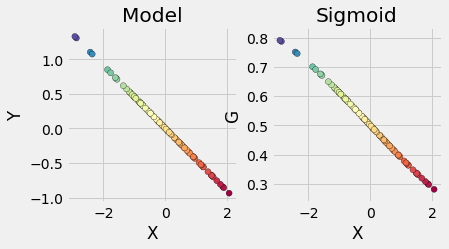

In [21]:
fig, axarray = plt.subplots(1, 2, figsize=(6,3))

axarray[0].set_title("Model")
axarray[0].set_ylabel("Y")
axarray[0].set_xlabel("X")
axarray[0].scatter(X[0,:], y[0,:], c=y[0,:], cmap="Spectral", edgecolor="k", lw=0.3)
axarray[1].set_title("Sigmoid")
axarray[1].scatter(X[0,:], G[0,:], c=y[0,:], cmap="Spectral", edgecolor="k", lw=0.3)
axarray[1].set_ylabel("G")
axarray[1].set_xlabel("X")

The scatter points are colormapped to the value of $Y$, so that there is a one-to-one correspondance between the two graphs. As you see, the larger values of $Y$ asymptote to 1 when a sigmoid function is applied, conversely very small/negative values of $Y$ go to zero. So in terms of probabilities, the sigmoid function is pretty useful. The trouble is, however, if we were to try and apply this to large values, like if we were to stack up our neural network model:

In [22]:
X_DIM = 1
Y_DIM = 1
HIDDEN_DIMS = (4,10,30,10,4)

model = LinearModel(X_DIM, Y_DIM, HIDDEN_DIMS)

In [23]:
Y = model(X)

G = sigmoid(Y)

Text(0.5, 0, 'X')

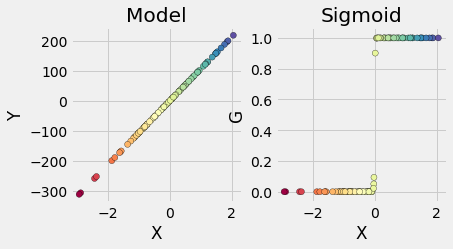

In [24]:
fig, axarray = plt.subplots(1, 2, figsize=(6,3))

axarray[0].set_title("Model")
axarray[0].set_ylabel("Y")
axarray[0].set_xlabel("X")
axarray[0].scatter(X[0,:], Y[0,:], c=Y[0,:], cmap="Spectral", edgecolor="k", lw=0.3)
axarray[1].set_title("Sigmoid")
axarray[1].scatter(X[0,:], G[0,:], c=Y[0,:], cmap="Spectral", edgecolor="k", lw=0.3)
axarray[1].set_ylabel("G")
axarray[1].set_xlabel("X")

See how the values of our sigmoid becomes basically one and zero? This is not very useful, as it basically means our neural network just outputs a step function. However, if we were to modify our neural network to include sigmoids between layers, the idea is that the numbers stay relatively small between each successive layer.

Below this, we're going to use class inheritance to reduce the need for repetitive code. Instead of copy-pasting our previous class, we're just going to inherit the common features of the model, including the `init_parameters` function and all of the other boilerplate stuff, and just modify the `forward` method to include activations. This is way of model development is object-oriented and very well supported in PyTorch, so it's advantageous to get used to this style of development.

In [25]:
class LinearModelWithActivation(LinearModel):
    """
    Added support for an activation function. The `activation` keyword argument provides a
    way for the user to provide a function that operates on X
    """
    def __init__(self, X_dim: int, Y_dim: int, hidden_dims: Tuple[int], activation=None):
        super().__init__(X_dim, Y_dim, hidden_dims)
        self.init_parameters()
        self.activation = activation
    
    def forward(self, X: np.ndarray):
        """
        Modified forward method to include an activation as well.
        """
        for w, b in zip(self.w, self.b):
            X = linear_layer(X, w, b)
            if self.activation:
                X = self.activation(X)
        return X

In [26]:
X_DIM = 1
Y_DIM = 1
HIDDEN_DIMS = (4,10,30,10,4)

model = LinearModelWithActivation(X_DIM, Y_DIM, HIDDEN_DIMS, activation=sigmoid)

In [27]:
Y = model(X)

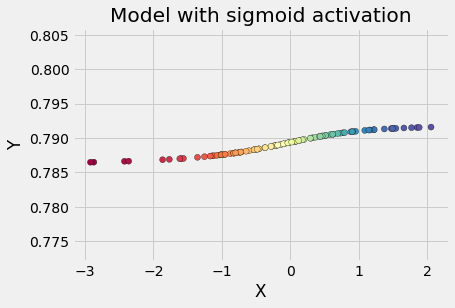

In [28]:
fig, ax = plt.subplots()

ax.set_title("Model with sigmoid activation")
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.scatter(X[0,:], Y[0,:], c=Y[0,:], cmap="Spectral", edgecolor="k", lw=0.3)
# ax.set_ylim([0.172, 0.18])

Notice how our model is now non-linear? With these simple sigmoid functions between hidden layers, we've induced non-linearities despite the fact that our model is just built with linear transformations! Not only that, the absolute values of $Y$ are now much smaller than the model without activations. There are a range of activation functions that can allow your model to grasp certain responses, and the figure below gives a brief overview.

Below we're also going to test out a few commonly used activation functions, and see effect they have on our model.

## ReLU

The rectified linear unit (ReLU) function is extremely common, and in this implementation I'm taking the vanilla ReLU function which basically takes $\mathrm{max}(X, 0)$; the larger value of either $X$, or zero. This function forces values to be non-negative, or at least zero.

In [29]:
def relu(X: np.ndarray):
    return np.maximum(X, np.zeros(X.shape))

## Softmax

This is a very similar function to the sigmoid—instead of making a single number range from [0,1], it forces a vector to sum up to one, such that each individual element can be thought of as a probability. This is the most commonly used activation for multilabel classification tasks.

$$ \mathrm{softmax} = \frac{\exp(X)}{\sum \exp(X)} $$

In [30]:
def softmax(X: np.ndarray):
    return np.exp(X) / np.exp(X).sum()

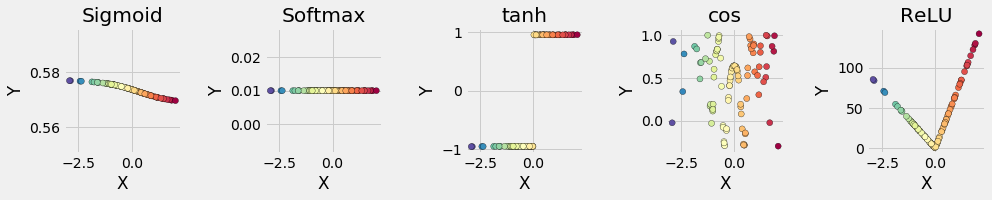

In [32]:
X_DIM = 1
Y_DIM = 1
HIDDEN_DIMS = (4,10,30,10,4)

activation_funcs = [sigmoid, softmax, np.tanh, np.cos, relu]
labels = ["Sigmoid", "Softmax", "tanh", "cos", "ReLU",]

fig, axarray = plt.subplots(1, len(activation_funcs), figsize=(14, 3))

for index, activation_func in enumerate(activation_funcs):
    model = LinearModelWithActivation(X_DIM, Y_DIM, HIDDEN_DIMS, activation=activation_func)
    Y = model(X)
    axarray[index].scatter(
        X[0,:], Y[0,:], c=y[0,:], cmap="Spectral", edgecolor="k", lw=0.3
    )
    axarray[index].set_title(labels[index])
    axarray[index].set_xlabel("X")
    axarray[index].set_ylabel("Y")
# This command spreads out the figures to not overlap
fig.tight_layout()

As you can see, the choice of function can change the output values quite dramatically, even if it's nominally the same input values $X$. You can also appreciate that, our model is only six layers deep (5 hidden layers), and we're already getting to the point where getting an intuition for what the output values will look like is kind of difficult. For example, $\tanh$ is a commonly used function that is very similar to sigmoid, which acts to compress values between [-1,1]. While it seemed like our sigmoid activations behaved well this time, $\tanh$ just seemed to output a step function. So, depending on how you stack up layers and activations, you can get very different behaviours and for this reason, deep learning (even without the learning part yet!) is very much an experimental field. Over time you're supposed to build up an intuition for what might work well, but it's very hard to dive into a new problem and say with confidence your model will work without having tried something in the first place.

# The "Learning" in Deep Learning

So far we've only implemented the core functioning parts of a neural network—we haven't done anything yet to actually solve problems. The "learning" in deep learning refers to finding parameters (which I'll refer to now as $\theta$, which broadly speaking includes weights $w$ and biases $b$)